# Importing

In [1]:
# Importing functions 

from functions.save_results import save_results, save_grid_results
from functions.split_data import list_test_train_df, data_prep_field
from functions.regression import training_regr, training_gkf_std, grid
from functions.plot_featimp import plot_feat_imp

In [2]:
# Importing Libraries

import os
import csv
import numpy as np
import pandas as pd
from copy import copy
from datetime import datetime as dt

# Dictionaries
import json
from pprint import pprint

# Iterate in loops
import itertools
from itertools import zip_longest

# Simpsons integration
from numpy import trapz
from scipy.integrate import simps

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To display df nicely in loops
from IPython.display import display 
# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

# # For displaying max rows in series
# pd.options.display.max_rows = 10

# ML Models

import time
# Pre.Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
# from sklearn.model_selection import StratifiedGroupKFold
# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Metrices
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error



# Importing data

# Prints the current working directory
os.getcwd()
# os.listdir()

## Finding Username folder to make general path for multi PC use

username = str(os.getcwd()).split('\\')[2]
user_path = r'C:/Users/'+username+'/'
user_path_complete = r'C:\Users\fahad\MegaSync\NMBU\GitHub\vPheno\\'
username, user_path

('fahad', 'C:/Users/fahad/')

# Models

In [3]:
models = [
    LinearRegression(),
    RandomForestRegressor(n_jobs=-1, random_state=1),
    GradientBoostingRegressor(random_state=1),
    # No overfitting
#     RandomForestRegressor(n_estimators=50,
#                           max_depth=100,
#                           min_samples_split=400,
#                           n_jobs=-1, random_state=1),
# #     Same results as default model but a tiny bit less overfiting
#     RandomForestRegressor(n_estimators=230,
#                           max_depth=20,
#                           min_samples_leaf=2,
#                           n_jobs=-1, random_state=1),
    Lasso(alpha=0, max_iter=50000, random_state=1, selection='random')
]

# Parameters

In [4]:
threshold_all = 'top_25'
sort_feature_imp = True

# show_feat_imp_plot = True
# save_feat_imp_plot = True
# save_results_now = True
scatter_plot = True
scatter_save = True


show_feat_imp_plot = False
save_feat_imp_plot = False
save_results_now = False
# scatter_plot = False
# scatter_save = False

scatter_marker_size = 3
scatter_fig_size = (5, 5)

group_feature = ['Name']



# Data Processing

In [5]:
## Declaring Import paths
main_path = r'./Data/'
path = r'./Data/3. merged data/'

# Create path folder if not exists already
os.makedirs(path, exist_ok=True)
# os.listdir(path)

# Making dictionary of files in each folder, in case there are multiple types of data
dict_paths = {}
def explore(starting_path):
    for dirpath, dirnames, filenames in os.walk(starting_path):
        dict_paths[dirpath.split('/')[-2]] = filenames
#     pprint(dict_paths)
explore(path)

# Data Preparation
## Creating list of complete files
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)

print(len(files_with_address), 'files found in the directory')
# files_with_address
# files_list

## Data Checking/control
### Check for duplicate filenames

print('Total number of files are :', len(files_list))
print('Number of unique file names are:', len(set(files_list)))
print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError



# Finding yield columns
## Importing Weather variables, yield columns, spectral indices, base indices columsn list

a_file = open(main_path+'vollebekk_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
weather_cols_vollebekk = json.loads(output_str)
a_file.close()
pprint(len(weather_cols_vollebekk))

a_file = open(main_path+'staur_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
weather_cols_staur = json.loads(output_str)
a_file.close()
pprint(len(weather_cols_staur))

a_file = open(main_path+"yield_columns.json", "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
yield_cols = json.loads(output_str)
a_file.close()
print(yield_cols)

a_file = open(main_path+"spectral_indices_columns.json", "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
spectral_indices_all = json.loads(output_str)
a_file.close()
print(spectral_indices_all)

a_file = open(main_path+"base_indices_columns.json", "r")
output_str = a_file.read()
# The file is imported as string
# Converting it to python format
base_indices = json.loads(output_str)
a_file.close()
print(base_indices)

## XXXXXX Defining categories of features

# ToDo: Add check for duplicate columns in the df
base_indices
spectral_indices_all 
drop_indices = ['EVI', 'GLI', 'MTCI']
spectral_indices = [x for x in spectral_indices_all if x not in drop_indices]

# Staur weather columns are all also present in Vollebekk weather so they can be use as general weather features
weather_features = weather_cols_staur.copy()
environment_var = weather_features + ['Staur_Env', 'Vollebekk_Env']
# yield_cols



14 files found in the directory
Total number of files are : 14
Number of unique file names are: 14
There is/are 0 duplicate file name/names.
80
80
['Days2Maturity', 'CodeName', 'Heading_Date', 'Pedigree', 'Lodging', 'GrainYield', 'Entry', 'Line', 'Name', 'Days2Heading', 'iBlock', 'Replicates', 'Maturity_Date', 'Block']
['NDVI', 'MTCI', 'DVI', 'GDVI', 'MTCI_CI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR']
['Blue', 'Green', 'Red', 'RedEdge', 'NIR']


In [6]:
#                                   base_indices + spectral_indices_all + environment_var,
#                                   base_indices + spectral_indices + weather_features,
#                                   spectral_indices + weather_features,
#                                   spectral_indices,

# Process

Graminor_2019_Simps ===== (600, 123)
Graminor_2019_Trapz ===== (600, 123)
Graminor_2020_Simps ===== (800, 123)
Graminor_2020_Trapz ===== (800, 123)
Masbasis_2019_Simps ===== (528, 124)
Masbasis_2019_Trapz ===== (528, 124)
Masbasis_2020_Simps ===== (624, 126)
Masbasis_2020_Trapz ===== (624, 126)
Robot_2020_Simps ===== (96, 125)
Robot_2020_Trapz ===== (96, 125)
Staur_2019_Simps ===== (1328, 127)
Staur_2019_Trapz ===== (1328, 127)
Staur_2020_Simps ===== (1488, 124)
Staur_2020_Trapz ===== (1488, 124)
Total imported 14
Masbasis_2019_Simps (528, 124) ==> (528, 118)
Masbasis_2019_Trapz (528, 124) ==> (528, 118)
Masbasis_2020_Simps (624, 126) ==> (624, 118)
Masbasis_2020_Trapz (624, 126) ==> (624, 118)
Robot_2020_Simps (96, 125) ==> (96, 118)
Robot_2020_Trapz (96, 125) ==> (96, 118)
Staur_2019_Simps (1328, 127) ==> (1328, 118)
Staur_2019_Trapz (1328, 127) ==> (1328, 118)
0  rows dropped in  Masbasis_2019_Simps
0  rows dropped in  Masbasis_2019_Trapz
112  rows dropped in  Masbasis_2020_Simps
11

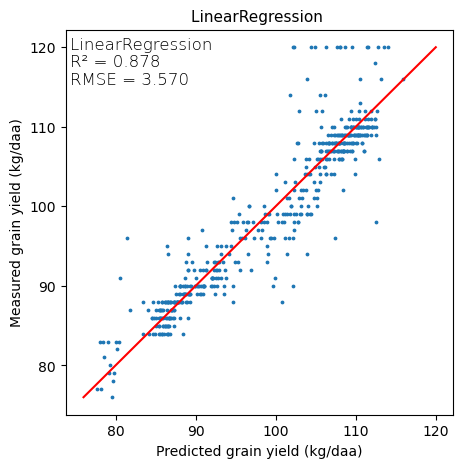

RandomForestRegressor(n_jobs=-1, random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=1))])
 RMSE Test: 3.641814        R2 Test: 0.873397
RMSE Train: 1.311000       R2 Train: 0.983315


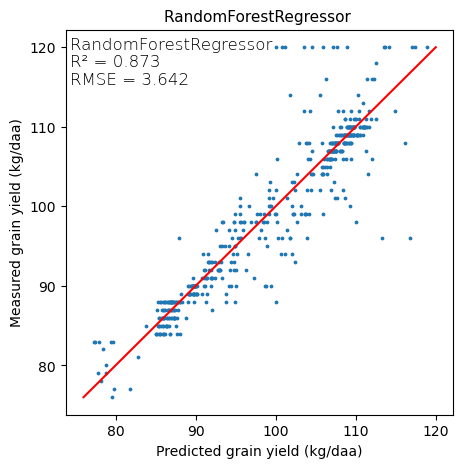

GradientBoostingRegressor(random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=1))])
 RMSE Test: 3.677817        R2 Test: 0.870882
RMSE Train: 2.403911       R2 Train: 0.943902


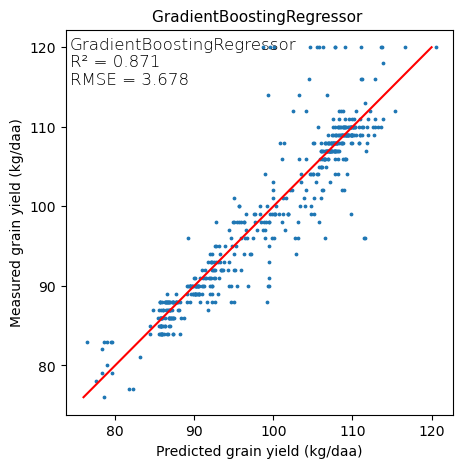

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6603.121940150708, tolerance: 10.816297619047617
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0, max_iter=50000, random_state=1, selection='random')
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0, max_iter=50000, random_state=1,
                       selection='random'))])
 RMSE Test: 3.630287        R2 Test: 0.874198
RMSE Train: 3.546460       R2 Train: 0.877904


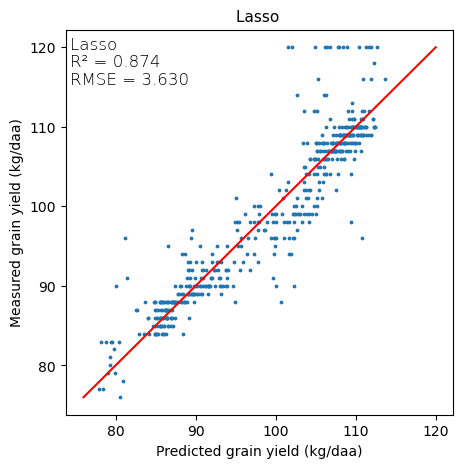

Graminor_2019_Simps ===== (600, 123)
Graminor_2019_Trapz ===== (600, 123)
Graminor_2020_Simps ===== (800, 123)
Graminor_2020_Trapz ===== (800, 123)
Masbasis_2019_Simps ===== (528, 124)
Masbasis_2019_Trapz ===== (528, 124)
Masbasis_2020_Simps ===== (624, 126)
Masbasis_2020_Trapz ===== (624, 126)
Robot_2020_Simps ===== (96, 125)
Robot_2020_Trapz ===== (96, 125)
Staur_2019_Simps ===== (1328, 127)
Staur_2019_Trapz ===== (1328, 127)
Staur_2020_Simps ===== (1488, 124)
Staur_2020_Trapz ===== (1488, 124)
Total imported 14
Masbasis_2019_Simps (528, 124) ==> (528, 118)
Masbasis_2019_Trapz (528, 124) ==> (528, 118)
Masbasis_2020_Simps (624, 126) ==> (624, 118)
Masbasis_2020_Trapz (624, 126) ==> (624, 118)
Robot_2020_Simps (96, 125) ==> (96, 118)
Robot_2020_Trapz (96, 125) ==> (96, 118)
Staur_2019_Simps (1328, 127) ==> (1328, 118)
Staur_2019_Trapz (1328, 127) ==> (1328, 118)
0  rows dropped in  Masbasis_2019_Simps
0  rows dropped in  Masbasis_2019_Trapz
112  rows dropped in  Masbasis_2020_Simps
11

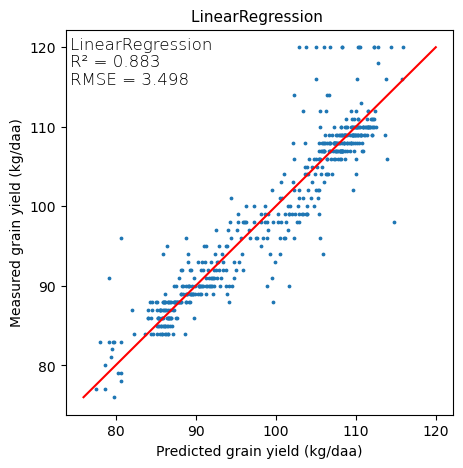

RandomForestRegressor(n_jobs=-1, random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=1))])
 RMSE Test: 3.597674        R2 Test: 0.876448
RMSE Train: 1.281050       R2 Train: 0.984069


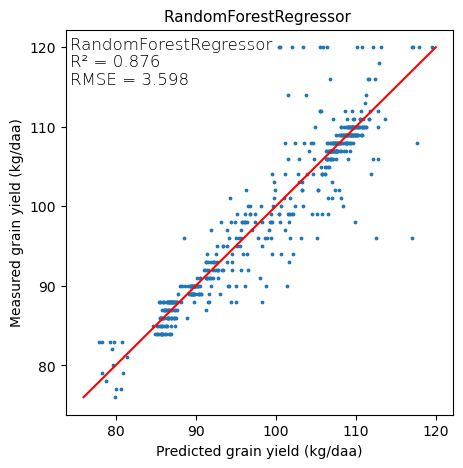

GradientBoostingRegressor(random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=1))])
 RMSE Test: 3.510834        R2 Test: 0.882340
RMSE Train: 2.265054       R2 Train: 0.950196


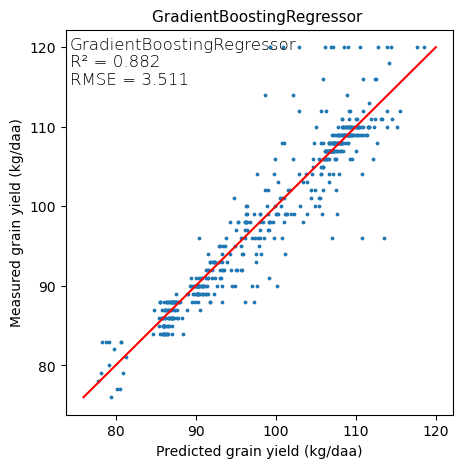

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6128.739643331506, tolerance: 10.816297619047617
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0, max_iter=50000, random_state=1, selection='random')
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0, max_iter=50000, random_state=1,
                       selection='random'))])
 RMSE Test: 3.576132        R2 Test: 0.877923
RMSE Train: 3.416693       R2 Train: 0.886676


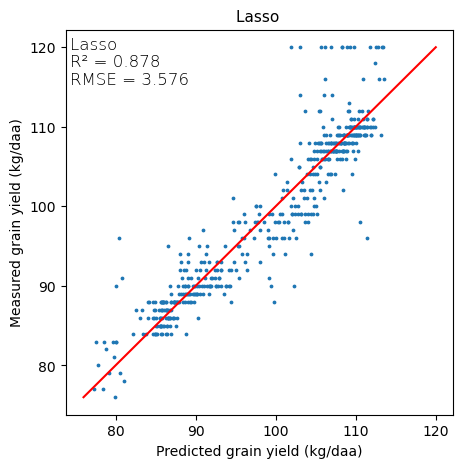

Graminor_2019_Simps ===== (600, 123)
Graminor_2019_Trapz ===== (600, 123)
Graminor_2020_Simps ===== (800, 123)
Graminor_2020_Trapz ===== (800, 123)
Masbasis_2019_Simps ===== (528, 124)
Masbasis_2019_Trapz ===== (528, 124)
Masbasis_2020_Simps ===== (624, 126)
Masbasis_2020_Trapz ===== (624, 126)
Robot_2020_Simps ===== (96, 125)
Robot_2020_Trapz ===== (96, 125)
Staur_2019_Simps ===== (1328, 127)
Staur_2019_Trapz ===== (1328, 127)
Staur_2020_Simps ===== (1488, 124)
Staur_2020_Trapz ===== (1488, 124)
Total imported 14
Graminor_2019_Simps (600, 123) ==> (600, 118)
Graminor_2019_Trapz (600, 123) ==> (600, 118)
Graminor_2020_Simps (800, 123) ==> (800, 118)
Graminor_2020_Trapz (800, 123) ==> (800, 118)
Masbasis_2019_Simps (528, 124) ==> (528, 118)
Masbasis_2019_Trapz (528, 124) ==> (528, 118)
Masbasis_2020_Simps (624, 126) ==> (624, 118)
Masbasis_2020_Trapz (624, 126) ==> (624, 118)
Robot_2020_Simps (96, 125) ==> (96, 118)
Robot_2020_Trapz (96, 125) ==> (96, 118)
Staur_2019_Simps (1328, 127) =

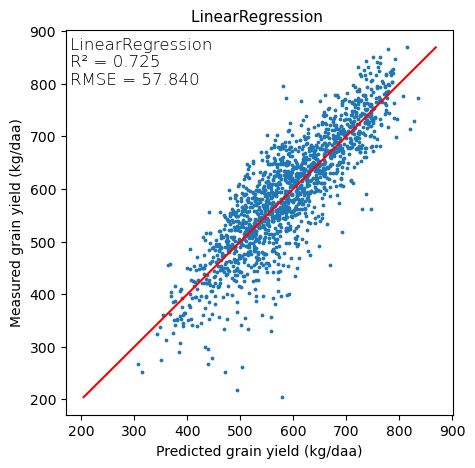

RandomForestRegressor(n_jobs=-1, random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=1))])
 RMSE Test: 57.457266        R2 Test: 0.728638
RMSE Train: 21.921674       R2 Train: 0.960628


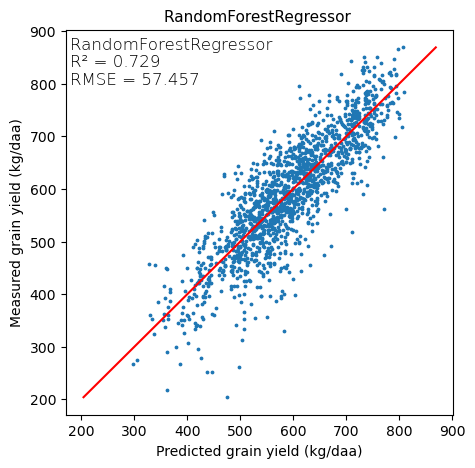

GradientBoostingRegressor(random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=1))])
 RMSE Test: 58.106775        R2 Test: 0.722469
RMSE Train: 50.445685       R2 Train: 0.791509


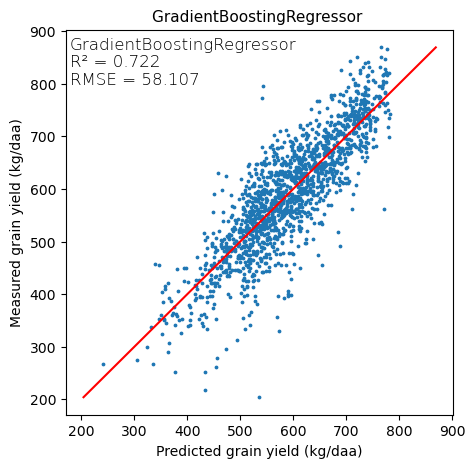

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5668285.7469418105, tolerance: 3822.816076338474
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0, max_iter=50000, random_state=1, selection='random')
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0, max_iter=50000, random_state=1,
                       selection='random'))])
 RMSE Test: 58.289400        R2 Test: 0.720721
RMSE Train: 60.163070       R2 Train: 0.703450


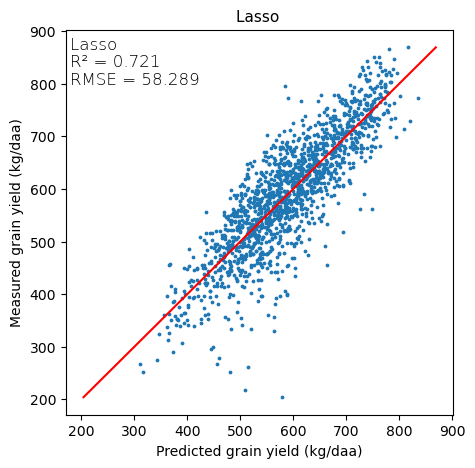

Graminor_2019_Simps ===== (600, 123)
Graminor_2019_Trapz ===== (600, 123)
Graminor_2020_Simps ===== (800, 123)
Graminor_2020_Trapz ===== (800, 123)
Masbasis_2019_Simps ===== (528, 124)
Masbasis_2019_Trapz ===== (528, 124)
Masbasis_2020_Simps ===== (624, 126)
Masbasis_2020_Trapz ===== (624, 126)
Robot_2020_Simps ===== (96, 125)
Robot_2020_Trapz ===== (96, 125)
Staur_2019_Simps ===== (1328, 127)
Staur_2019_Trapz ===== (1328, 127)
Staur_2020_Simps ===== (1488, 124)
Staur_2020_Trapz ===== (1488, 124)
Total imported 14
Graminor_2019_Simps (600, 123) ==> (600, 118)
Graminor_2019_Trapz (600, 123) ==> (600, 118)
Graminor_2020_Simps (800, 123) ==> (800, 118)
Graminor_2020_Trapz (800, 123) ==> (800, 118)
Masbasis_2019_Simps (528, 124) ==> (528, 118)
Masbasis_2019_Trapz (528, 124) ==> (528, 118)
Masbasis_2020_Simps (624, 126) ==> (624, 118)
Masbasis_2020_Trapz (624, 126) ==> (624, 118)
Robot_2020_Simps (96, 125) ==> (96, 118)
Robot_2020_Trapz (96, 125) ==> (96, 118)
Staur_2019_Simps (1328, 127) =

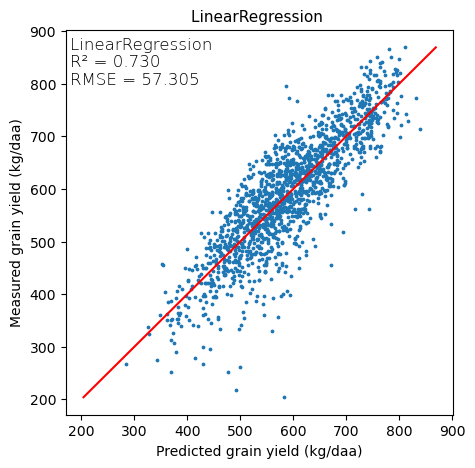

RandomForestRegressor(n_jobs=-1, random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=1))])
 RMSE Test: 56.441286        R2 Test: 0.738150
RMSE Train: 21.547791       R2 Train: 0.961960


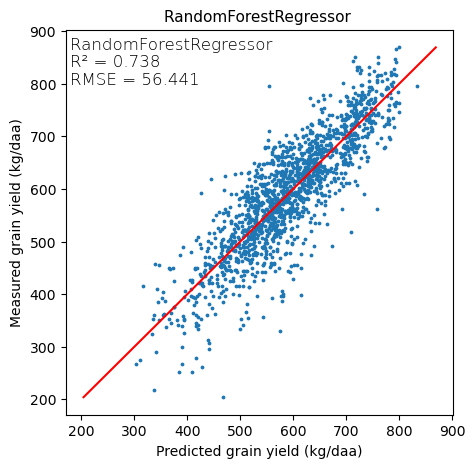

GradientBoostingRegressor(random_state=1)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=1))])
 RMSE Test: 56.829097        R2 Test: 0.734540
RMSE Train: 50.439701       R2 Train: 0.791559


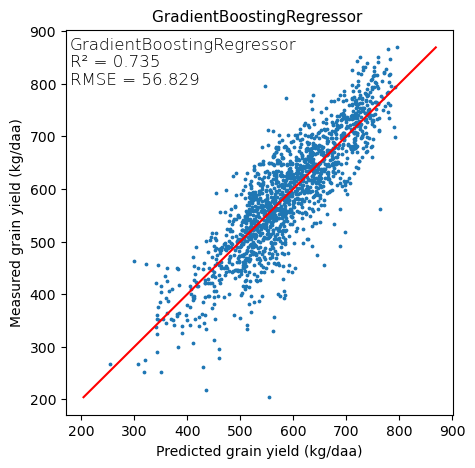

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5467397.799195101, tolerance: 3822.816076338474
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0, max_iter=50000, random_state=1, selection='random')
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0, max_iter=50000, random_state=1,
                       selection='random'))])
 RMSE Test: 57.786949        R2 Test: 0.725515
RMSE Train: 59.087343       R2 Train: 0.713960


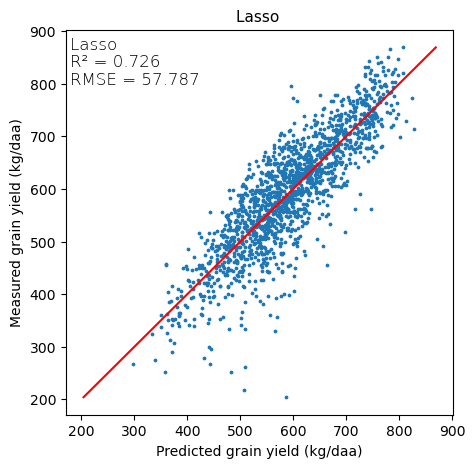

In [7]:
for target_features in [
    ['Days2Maturity'],
    ['GrainYield']
]:

    for agg_method in ['Simpsons', 'Trapezoid']:

        feature_counter = 0
        for training_features in [
                                  base_indices + spectral_indices_all + weather_features,
#                                   spectral_indices_all + weather_features,
#                                   base_indices + spectral_indices_all,
#                                   base_indices + weather_features, 
#                                   spectral_indices_all,
#                                   weather_features,
#                                   base_indices,
                                 ]:
            feature_counter += 1

            # Importing data files to Pandas

            all_df = []
            for data in files_with_address:
                file_name = os.path.splitext(os.path.basename(data))[0]

                # Replce all invalid characters in the name
                file_name = file_name.replace(" ", "_")
                file_name = file_name.replace("-", "_")
                file_name = file_name.replace(")", "")
                file_name = file_name.replace("(", "")
                df_name = file_name.replace(".", "")
                # Test: Check if the same date is already present in the current dict key
                if df_name in all_df:
                    print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
                    raise NameError
                all_df.append(df_name)

                locals()[df_name] = pd.read_csv(data, index_col=False)
                print(df_name, '=====', locals()[df_name].shape)
            # all_df

            print(f'Total imported {len(all_df)}')
            # all_df

            # Dropping DF which donot have the Target Feature
            # Dropping unnecessary columns
            all_df_dm = []
            for df in all_df:
                temp_df = locals()[df].copy()
                if target_features[0] in temp_df.columns.tolist():
                    all_df_dm.append(df)
            #         print(df)

            all_df_simps = [x for x in all_df_dm if 'Simps' in x]
            all_df_trapz = [x for x in all_df_dm if 'Trapz' in x]
            # all_df_simps, all_df_trapz

            # Dropping unnecessary columns

            for df in all_df_dm:
                temp_df = locals()[df].copy()
                locals()[df] = temp_df[base_indices+spectral_indices_all+environment_var+['Name',target_features[0]]]
                print(df, temp_df.shape, '==>', locals()[df].shape)


            # Dropping Missing values
            # Dropping rows with missing value in any column

            for df in all_df_dm:
                temp_df = locals()[df].copy()
                locals()[df] = temp_df.dropna(axis=0)
                print(temp_df.shape[0] - locals()[df].shape[0], ' rows dropped in ', df)
            #     print(locals()[df].shape[0])

            # Normalizing the data using Z-Score from scipy

            from scipy.stats import zscore

            for df in all_df_dm:
                temp_df = locals()[df].copy()
                for col in temp_df.columns:
                    # Checking if the column is not a yield column
                    if col not in yield_cols+environment_var:
                        temp_df[col] = zscore(temp_df[col])
                locals()[df] = temp_df.copy()
                print(df)



            ## Declaring export paths
            if target_features[0] == 'GrainYield':
                export_path = './Data/4. results_GY/'
            elif target_features[0] == 'Days2Maturity':
                export_path = './Data/4. results_DM/'

            # Checking which data to use
            if agg_method == 'Simpsons':
                all_df_now = all_df_simps.copy()
                export_path_plots = export_path+'/Simps/'
            elif agg_method == 'Trapezoid': 
                all_df_now = all_df_trapz.copy()
                export_path_plots = export_path+'/Trapz/'

                
            # Create export_path folder if not exists already
            os.makedirs(export_path, exist_ok=True)
            os.makedirs(export_path_plots, exist_ok=True)


            ## Variations in Datasets

            ### All data mixed

            temp_list = [x for x in all_df_now if not 'Robot' in x]

            # Making list of df for conct before training
            # This is different form list of srtings, as this is a list of actual dataframes
            df_list = []
            for x in temp_list:
                df_list.append(locals()[x])

            df_ = pd.concat(df_list)

            # Shuffeling all the items
            df_shuffle = df_.sample(frac=1, random_state=1).reset_index(drop=True)

            X = df_shuffle[training_features]
            y = df_shuffle[target_features].values.ravel()
            groups = df_shuffle[group_feature].values.ravel()

            gkf = list(GroupKFold(n_splits=6).split(X, y, groups))
            # gkf = list(StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=1).split(X, y, groups))

            #     Getting scores using cross_val_score
            for model in models:
                save_suffix='all_mixed'
                train_field='all_mix'
                test_field='all_mix'
#                 scatter_title = save_suffix
#                 scatter_title = '\n Integrated data using Simpson\'s rule'
#                 scatter_title = '\n Integrated data using Composite Trapezoidal Rule'
                scatter_title = ''
    
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.33, random_state=1)

                scatter_params = [scatter_plot, scatter_title, scatter_save, export_path_plots, feature_counter, 
                                  scatter_marker_size, scatter_fig_size]
                importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp, y_pred = training_regr(
                    model, X_train, y_train, X_test, y_test, scatter_params)

#                 importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_gkf_std(
#                     model, X, y, gkf)
                if importances is not None:
                    plot_feat_imp(feature_importance=importances,
                                  model=model,
                                  train_feat=training_features,
                                  feature_group = feature_counter,
                                  threshold=threshold_all,
                                  sort_feat=sort_feature_imp,
                                  show_plot=show_feat_imp_plot,
                                  save_plot=save_feat_imp_plot,
                                  export_path=export_path_plots,
                                  save_suffix='all_mixed')
                if save_results_now:
                    save_results(model=model,
                                 agg_method=agg_method,
                                 train_field='all_mix',
                                 test_field='all_mix',
                                 features_all=[training_features,
                                               base_indices,
                                               spectral_indices_all,
                                               spectral_indices,
                                               weather_features, export_path],
                                 importances=importances,
                                 RMSE_test=RMSE_test_temp,
                                 RMSE_train=RMSE_train_temp,
                                 R2_test=R2_test_temp,
                                 R2_train=R2_train_temp,
                                 GKF_CV=GKF_CV_temp)

#             ### Within same datasets:

#             # Iterating through all possible permutations of the fields dataset
#             for df in all_df_now:
#                 df_ = locals()[df].copy()

#                 X = df_[training_features]
#                 y = df_[target_features].values.ravel()
#                 groups = df_[group_feature].values.ravel()

#                 gkf = list(GroupKFold(n_splits=6).split(X, y, groups))
#                 print(df)
#                 #     Getting scores using cross_val_score
#                 for model in models:
#                     print(df)
#                     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_gkf_std(
#                         model, X, y, gkf)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix=str(df+'_66-33'))
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=df,
#                                      test_field=df,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                      R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

#             ### One against all - one2one

#             # # Iterating through all possible permutations of the fields dataset

#             # for i in itertools.permutations(all_df_now, 2):
#             #     train_df = locals()[i[0]].copy()
#             #     test_df = locals()[i[1]].copy()


#             #     X_train = train_df[training_features]
#             #     y_train = train_df[target_features].values.ravel()
#             #     X_test = test_df[training_features]
#             #     y_test = test_df[target_features].values.ravel()

#             #     # Getting scores using cross_val_score
#             #     for model in models:
#             #         print('Training: ', i[0],'Test: ', i[1], ' : ', model)
#             #         importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#             #             model, X_train, y_train, X_test, y_test)
#             #         if importances is not None:
#             #             plot_feat_imp(feature_importance=importances,
#             #                           model=model,
#             #                           train_feat=training_features,
#             #                           feature_group = feature_counter,
#             #                           threshold=threshold_all,
#             #                           sort_feat=sort_feature_imp,
#             #                           show_plot=show_feat_imp_plot,
#             #                           save_plot=save_feat_imp_plot,
#             #                           export_path=export_path_plots,
#             #                           save_suffix=i[0]+'_Vs_'+i[1])
#             #         if save_results_now:
#             #             save_results(model=model,
#             #                          agg_method=agg_method,
#             #                          train_field=i[0],
#             #                          test_field=i[1],
#             #                          features_all=[training_features,
#             #                                        base_indices,
#             #                                        spectral_indices_all,
#             #                                        spectral_indices,
#             #                                        weather_features, export_path],
#             #                          importances=importances,
#             #                          RMSE_test=RMSE_test_temp,
#             #                          RMSE_train=RMSE_train_temp,
#             #                          R2_test=R2_test_temp,
#             #                          R2_train=R2_train_temp,
#             #                          GKF_CV=GKF_CV_temp)

#             ### One aganist all together

#             # Iterating through all possible permutations of the fields dataset
#             for df in all_df_now:
#                 if 'Robot' not in df:
#                     temp_list = [
#                         x for x in all_df_now if not 'Robot' in x if not df in x
#                     ]
#                     print(df, temp_list)

#                     # Making list of df for conct before training
#                     # This is different form list of srtings, as this is a list of actual dataframes
#                     train_df_list = []
#                     for x in temp_list:
#                         train_df_list.append(locals()[x])

#                     train_df = pd.concat(train_df_list)
#                     test_df = locals()[df].copy()

#                     X_train = train_df[training_features]
#                     y_train = train_df[target_features].values.ravel()
#                     X_test = test_df[training_features]
#                     y_test = test_df[target_features].values.ravel()

#                     # Getting scores using cross_val_score
#                     for model in models:
#                         print('Training: All  ', 'Test: ', df, ' : ', model)
#                         importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#                             model, X_train, y_train, X_test, y_test)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix=df+'_Vs_all')
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=temp_list,
#                                      test_field=df,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                      R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

#             ### Vollebekk ALL vs Staur ALL

#             #### Training Staur, Test Vollebekk

#             train_str_list, test_str_list = list_test_train_df(all_df_now,
#                                                                train_field = 'Staur', 
#                                                                test_field = 'Vollebekk', 
#                                                                year = 'all')
#             suffix_title = 'Staur_Vs_Vollebekk_all'

#             train_df_list = []
#             test_df_list = []
#             for x in train_str_list:
#                 train_df_list.append(locals()[x])
#             for x in test_str_list:
#                 test_df_list.append(locals()[x])

#             if len(train_str_list) > 0 and len(test_str_list) > 0:
#                 train_df = pd.concat(train_df_list)
#                 test_df = pd.concat(test_df_list)

#                 X_train = train_df[training_features]
#                 y_train = train_df[target_features].values.ravel()
#                 X_test = test_df[training_features]
#                 y_test = test_df[target_features].values.ravel()

#                 # Getting scores using cross_val_score
#                 for model in models:
#                     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#                         model, X_train, y_train, X_test, y_test)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix='Staur_Vs_Vollebekk_all')
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=train_str_list,
#                                      test_field=test_str_list,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                      R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

#             #### Training Vollebekk, Test Staur

#             train_str_list, test_str_list = list_test_train_df(all_df_now,
#                                                                train_field = 'Vollebekk', 
#                                                                test_field = 'Staur', 
#                                                                year = 'all')

#             suffix_title = 'VollebekK_Vs_Staur_all'

#             train_df_list = []
#             test_df_list = []
#             for x in train_str_list:
#                 train_df_list.append(locals()[x])
#             for x in test_str_list:
#                 test_df_list.append(locals()[x])

#             if len(train_str_list) > 0 and len(test_str_list) > 0:
#                 train_df = pd.concat(train_df_list)
#                 test_df = pd.concat(test_df_list)

#                 X_train = train_df[training_features]
#                 y_train = train_df[target_features].values.ravel()
#                 X_test = test_df[training_features]
#                 y_test = test_df[target_features].values.ravel()

#                 # Getting scores using cross_val_score
#                 for model in models:
#                     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#                         model, X_train, y_train, X_test, y_test)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix='Staur_Vs_Vollebekk_all')
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=train_str_list,
#                                      test_field=test_str_list,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                      R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

#             ### 2020 Vollebekk vs 2020 Staur

#             #### Training Staur, Test Vollebekk

#             train_str_list, test_str_list = list_test_train_df(all_df_now,
#                                                                train_field = 'Staur', 
#                                                                test_field = 'Vollebekk', 
#                                                                year = '2020')
#             suffix_title = 'Staur_Vs_Vollebekk_2020'

#             train_df_list = []
#             test_df_list = []
#             for x in train_str_list:
#                 train_df_list.append(locals()[x])
#             for x in test_str_list:
#                 test_df_list.append(locals()[x])

#             if len(train_str_list) > 0 and len(test_str_list) > 0:
#                 train_df = pd.concat(train_df_list)
#                 test_df = pd.concat(test_df_list)

#                 X_train = train_df[training_features]
#                 y_train = train_df[target_features].values.ravel()
#                 X_test = test_df[training_features]
#                 y_test = test_df[target_features].values.ravel()

#                 # Getting scores using cross_val_score
#                 for model in models:
#                     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#                         model, X_train, y_train, X_test, y_test)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix='Staur_Vs_Vollebekk_all')
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=train_str_list,
#                                      test_field=test_str_list,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                      R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

#             #### Training Vollebekk, Test Staur

#             train_str_list, test_str_list = list_test_train_df(all_df_now,
#                                                                train_field = 'Vollebekk', 
#                                                                test_field = 'Staur', 
#                                                                year = '2020')
#             suffix_title = 'VollebekK_Vs_Staur_2020'

#             train_df_list = []
#             test_df_list = []
#             for x in train_str_list:
#                 train_df_list.append(locals()[x])
#             for x in test_str_list:
#                 test_df_list.append(locals()[x])

#             if len(train_str_list) > 0 and len(test_str_list) > 0:
#                 train_df = pd.concat(train_df_list)
#                 test_df = pd.concat(test_df_list)

#                 X_train = train_df[training_features]
#                 y_train = train_df[target_features].values.ravel()
#                 X_test = test_df[training_features]
#                 y_test = test_df[target_features].values.ravel()

#                 # Getting scores using cross_val_score
#                 for model in models:
#                     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#                         model, X_train, y_train, X_test, y_test)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix='Staur_Vs_Vollebekk_all')
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=train_str_list,
#                                      test_field=test_str_list,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                      R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

#             ### 2019 Vollebekk vs 2019 Staur

#             #### Training Staur, Test Vollebekk

#             train_str_list, test_str_list = list_test_train_df(all_df_now,
#                                                                train_field = 'Staur', 
#                                                                test_field = 'Vollebekk', 
#                                                                year = '2019')
#             suffix_title = 'Staur_Vs_Vollebekk_2019'

#             train_df_list = []
#             test_df_list = []
#             for x in train_str_list:
#                 train_df_list.append(locals()[x])
#             for x in test_str_list:
#                 test_df_list.append(locals()[x])

#             if len(train_str_list) > 0 and len(test_str_list) > 0:
#                 train_df = pd.concat(train_df_list)
#                 test_df = pd.concat(test_df_list)

#                 X_train = train_df[training_features]
#                 y_train = train_df[target_features].values.ravel()
#                 X_test = test_df[training_features]
#                 y_test = test_df[target_features].values.ravel()

#                 # Getting scores using cross_val_score
#                 for model in models:
#                     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#                         model, X_train, y_train, X_test, y_test)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix='Staur_Vs_Vollebekk_all')
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=train_str_list,
#                                      test_field=test_str_list,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                      R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

#             #### Training Vollebekk, Test Staur

#             train_str_list, test_str_list = list_test_train_df(all_df_now,
#                                                                train_field = 'Vollebekk', 
#                                                                test_field = 'Staur', 
#                                                                year = '2019')
#             suffix_title = 'Vollebekk_Vs_Staur_2019'

#             train_df_list = []
#             test_df_list = []
#             for x in train_str_list:
#                 train_df_list.append(locals()[x])
#             for x in test_str_list:
#                 test_df_list.append(locals()[x])

#             if len(train_str_list) > 0 and len(test_str_list) > 0:
#                 train_df = pd.concat(train_df_list)
#                 test_df = pd.concat(test_df_list)

#                 X_train = train_df[training_features]
#                 y_train = train_df[target_features].values.ravel()
#                 X_test = test_df[training_features]
#                 y_test = test_df[target_features].values.ravel()
#                 print('ok')
#                 # Getting scores using cross_val_score
#                 for model in models:
#                     importances, RMSE_test_temp, RMSE_train_temp, R2_test_temp, R2_train_temp, GKF_CV_temp = training_regr(
#                         model, X_train, y_train, X_test, y_test)
#                     if importances is not None:
#                         plot_feat_imp(feature_importance=importances,
#                                       model=model,
#                                       train_feat=training_features,
#                                       feature_group = feature_counter,
#                                       threshold=threshold_all,
#                                       sort_feat=sort_feature_imp,
#                                       show_plot=show_feat_imp_plot,
#                                       save_plot=save_feat_imp_plot,
#                                       export_path=export_path_plots,
#                                       save_suffix='Staur_Vs_Vollebekk_all')
#                     if save_results_now:
#                         save_results(model=model,
#                                      agg_method=agg_method,
#                                      train_field=train_str_list,
#                                      test_field=test_str_list,
#                                      features_all=[training_features,
#                                                    base_indices,
#                                                    spectral_indices_all,
#                                                    spectral_indices,
#                                                    weather_features, export_path],
#                                      importances=importances,
#                                      RMSE_test=RMSE_test_temp,
#                                      RMSE_train=RMSE_train_temp,
#                                        R2_test=R2_test_temp,
#                                      R2_train=R2_train_temp,
#                                      GKF_CV=GKF_CV_temp)

